In [2]:
from IPython.display import Image

# Introduction

The code is used to correct the distortion of CBED patterns caused by projector lens aberration.

The distortion of CBED pattern will introduce unexpected deformation and artifacts into the electron ptychography results. However, in STEM equipment, the projector lens is difficult to adjust into ideal state. This code can help researchers to fit the distortion field based on reference datasets collected by known materials and correct distortion of entire 4D-STEM dataset.

The code includes four python notebooks. The first one “GetCenters” is to fit the center of the Bragg disks in the position averaged CBED pattern of reference data. A corresponding code “RefineOvalCenters” can be used to refine the positions of centers. The second one “FitZernikeModel”  is used to fit the distortion field into Zernike Model at certain camera length. The third one “CorrectEntireDataset” is used to correct all 4D-STEM data collected at the same camera length. 

This notebook is intended to be a public resource. As such, if you see any glaring inaccuracies or if a critical topic is missing, please feel free to point it out or submit a pull request to improve the notebook.


# Requiered libaries 

cv2(OpenCV): OpenCV provides a real-time optimized Computer Vision library, tools, and hardware.
imutils: make basic image processing functions such as translation, rotation, resizing, , sorting contours, detecting edges.
argparse: Parser for command-line options, arguments and sub-commands. 
numpy: Provides a fast numerical array structure and helper functions.
scipy: SciPy provides algorithms for optimization, integration, interpolation, eigenvalue problems,statistics.
Zernike: Python code to handle complex- and real-valued Zernike polynomials. 
hyperspy: Open source Python framework for exploring, visualizing and analyzing multi-dimensional data
matplotlib: Basic plotting library in Python; most other Python plotting libraries are built on top of it.
skimage: scikit-image is a collection of algorithms for image processing.

# Overview 

The code contains three notebooks:
0. Transform the 4D-STEM file into ".npy" file (Only be needed for the case when the data file is ".mrc" or other file type)
1. GetCenters
(1-1 RefineOvalCenters)
2. FitZernikeModel
3. CorrectEntireDataset

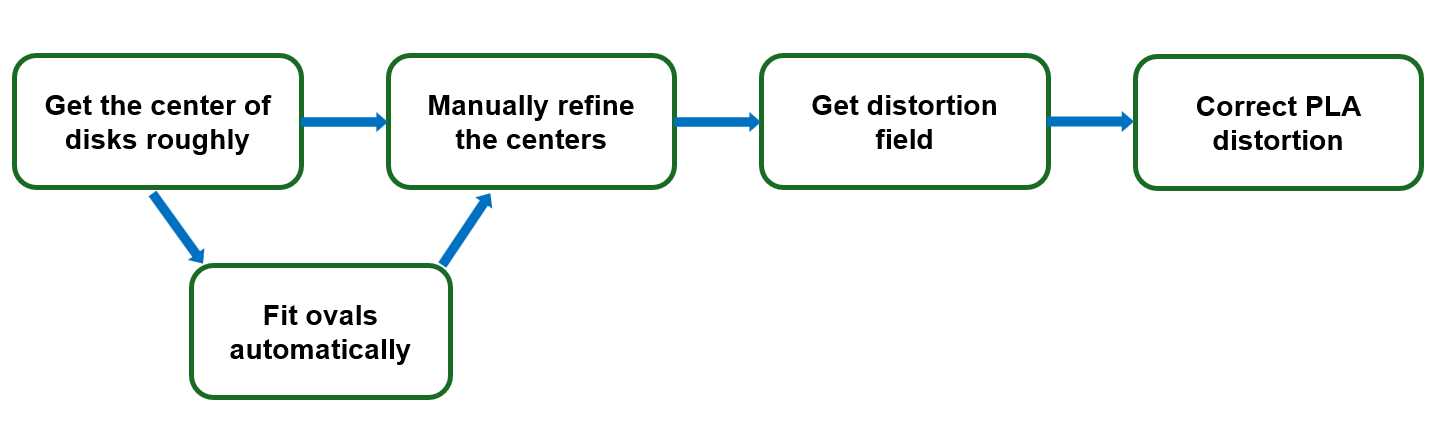

In [6]:
Image(filename = 'workflow.png', width=1000, height=800)

# Step 1 find the position of centers of the Bragg disks. 

### Import the libraies

In [1]:
import cv2
import math
import imutils
import argparse 
import numpy as np
from scipy import optimize
import hyperspy.api as hs
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import hsv_to_rgb
from mpl_toolkits.axes_grid1 import AxesGrid

### Step 1.1 load the data

load the 4D-STEM dataset and save the position averaged CBED pattern (pacbed)

In [2]:
# path of data
folder = "E:/Nion_PL_aberr_20231023/5_15/"

In [ ]:
# only do it when you load the 4D data first time
# Notice that the data type should be float32,if not transform them into float32 at first.
dat4d = np.load(folder + "data.npy")
pacbed = np.average(dat4d, axis=(0,1))
np.save(folder + "pacbed.npy")

Text(0.5, 1.0, 'CBED')

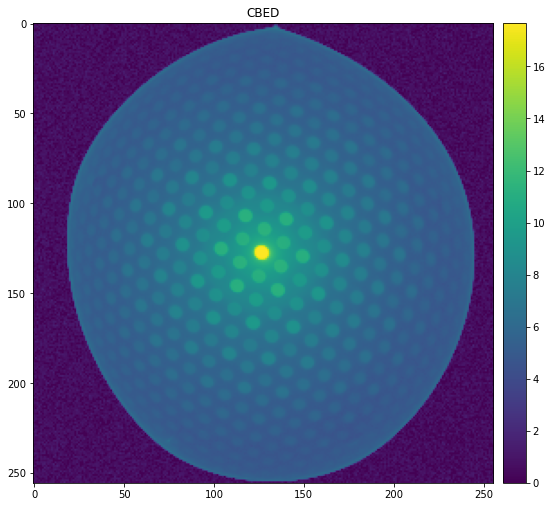

In [7]:
# load the pacbed pattern 
gray = np.load(folder + "pacbed.npy")
gray = np.log(gray*10000+1)
fig =plt.figure(1, figsize=(30, 30))
grid=AxesGrid(fig, 236, nrows_ncols=(1,1),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(gray, cmap=plt.cm.viridis)
grid.cbar_axes[0].colorbar(im)
grid[0].set_title("CBED")

### Step 1.2 Get the outlines of Bragg disks

Text(0.5, 1.0, 'grad')

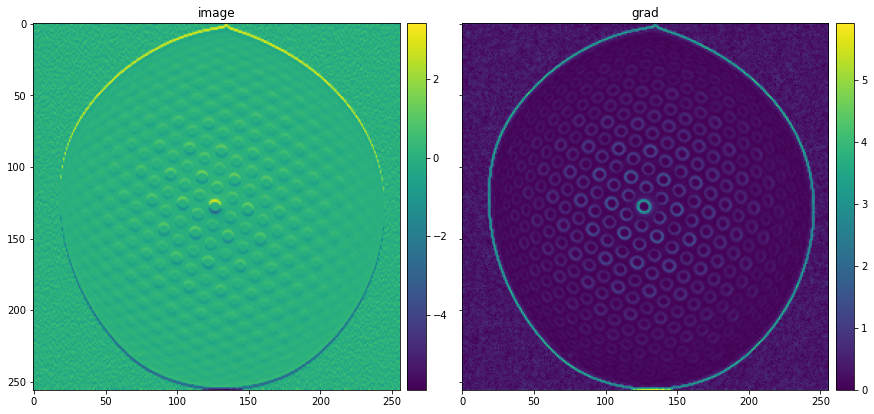

In [10]:
# get the outline of disks
img_gradx, img_grady = np.gradient(gray)
img_grad = np.sqrt(np.square(img_gradx)+np.square(img_grady))
fig =plt.figure(1, figsize=(50, 30))
grid=AxesGrid(fig, 236, nrows_ncols=(1,2),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im1=grid[0].imshow(img_gradx, cmap=plt.cm.viridis)
im2=grid[1].imshow(img_grad, cmap=plt.cm.viridis)
grid.cbar_axes[0].colorbar(im1)
grid.cbar_axes[1].colorbar(im2)
grid[0].set_title("image")
grid[1].set_title("grad")

In [11]:
#remove the outline of pattern
center_mask = np.zeros(gray.shape)
Y, X = np.indices(gray.shape)
x_center = gray.shape[0]/2
y_center = gray.shape[1]/2
radius_cm =gray.shape[0]*0.3  #radius of center mask to project the central disks
center_mask[np.where(np.sqrt((X-x_center)**2 + (Y-y_center)**2)>radius_cm)] = 1.0
gray_masked = img_grad*center_mask
out_thresh = gray.max()*0.3 #threshhold of the remianed singal value 
img_grad[np.where(gray_masked>out_thresh)] = 0

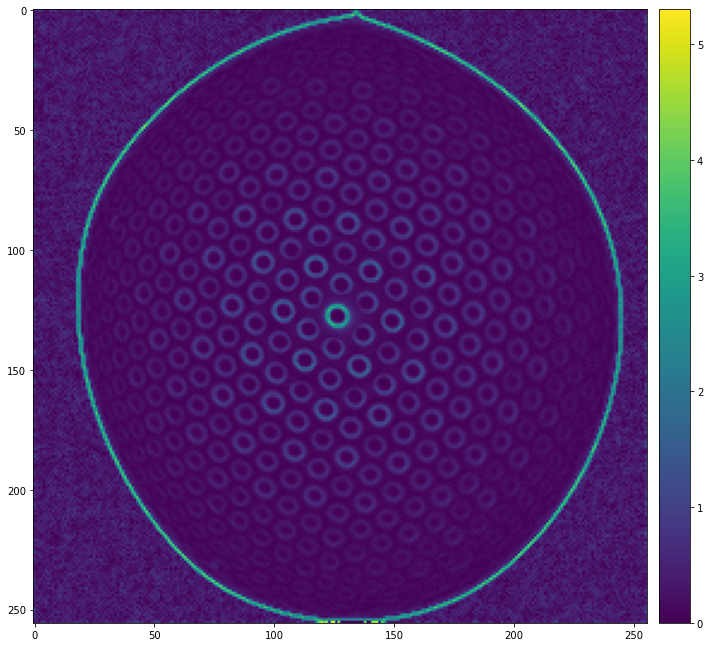

In [12]:
# check the result
fig =plt.figure(1, figsize=(40, 40))
grid=AxesGrid(fig, 236, nrows_ncols=(1,1),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(img_grad, cmap=plt.cm.viridis) 
grid.cbar_axes[0].colorbar(im)

In [13]:
#remove the outline of pattern
center_mask = np.zeros(gray.shape)
Y, X = np.indices(gray.shape)
x_center = gray.shape[0]/2
y_center = gray.shape[1]/2
radius_cm =gray.shape[0]*0.3  #radius of center mask to project the central disks
center_mask[np.where(np.sqrt((X-x_center)**2 + (Y-y_center)**2)>radius_cm)] = 1.0
gray_masked = img_grad*center_mask
out_thresh = gray.max()*0.07 #threshhold of the remianed singal value 
img_grad[np.where(gray_masked>out_thresh)] = 0

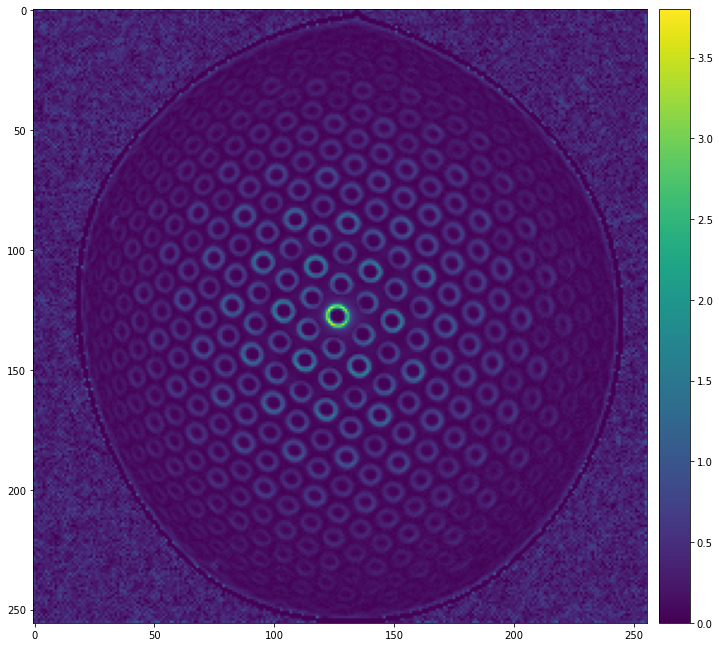

In [14]:
# check the result
fig =plt.figure(1, figsize=(40, 40))
grid=AxesGrid(fig, 236, nrows_ncols=(1,1),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(img_grad, cmap=plt.cm.viridis) 
grid.cbar_axes[0].colorbar(im)

### Step 1.3 Fit the centers of Bragg disks roughly

In [ ]:
#Fucntions for fit the position of Bragg disks
def MatchTemplate(I,template,radius,threshold):
    kernel=cv2.getStructuringElement(cv2.MORPH_RECT,(radius, radius))
    corr_map = cv2.matchTemplate(I,template,cv2.TM_CCOEFF_NORMED)
    dialated_corr= cv2.dilate(corr_map, kernel)
    peak_idx=np.asarray(np.where((corr_map>= dialated_corr)&(corr_map>threshold))).T
    return corr_map, peak_idx
def RefineTemplate(I,template,radius,threshold):
    corr_map, peak_idx = MatchTemplate(I,template,radius,threshold)
    point_num = peak_idx.shape[0]
    new_template = np.zeros_like(template)
    for i in range(point_num):
        x_pos = peak_idx[i, 1]
        y_pos = peak_idx[i, 0]
        new_template+= I[y_pos:(y_pos+template.shape[0]), x_pos:(x_pos+template.shape[1])]
    new_template/=point_num
    #pick up the maximum from the template.
    max_loc = np.unravel_index(np.argmax(new_template), new_template.shape)
    row_shift = max_loc[0]-int(new_template.shape[0]/2)
    col_shift = max_loc[1]-int(new_template.shape[1]/2)
    peak_idx[:,0] += row_shift
    peak_idx[:,1] += col_shift
    filtered_peak = []
    #generate the tempalte again.
    new_template = np.zeros_like(template)
    for i in range(point_num):
        x_pos = peak_idx[i, 1]
        y_pos = peak_idx[i, 0]
        if (x_pos<0):
            continue
        if (y_pos<0):
            continue
        if (y_pos+template.shape[0]>I.shape[0]):
            continue
        if (x_pos+template.shape[1]>I.shape[1]):
            continue
        filtered_peak.append([y_pos, x_pos])
        new_template+= I[y_pos:(y_pos+template.shape[0]), x_pos:(x_pos+template.shape[1])]
    new_template/=point_num
    filtered_peak = np.asarray(filtered_peak)
    return new_template, corr_map, filtered_peak
def MatchSubpixTemplate(I, template, peak_idx):
    sub_peak = np.zeros(peak_idx.shape, np.float32)
    for i in range(peak_idx.shape[0]):
        x_pos = peak_idx[i, 1]
        y_pos = peak_idx[i, 0]
        sub_frame = I[y_pos:(y_pos+template.shape[0]), x_pos:(x_pos+template.shape[1])].copy()
        #corr(T(x, y), M(x', y'))
        #x' = x+ dx, y' = y+ dy
        #during the transformECC the affine transformation is applied to the moving frame but not the static frame.
        warp_matrix = np.eye(2, 3, dtype=np.float32)
        criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 100, 1e-2)
        (cc, warp_matrix) = cv2.findTransformECC(sub_frame, template, warp_matrix, cv2.MOTION_TRANSLATION, criteria)
        sub_peak[i,0] = peak_idx[i,0] - warp_matrix[1, 2]+int(template.shape[0]/2)
        sub_peak[i,1] = peak_idx[i,1] - warp_matrix[0, 2]+int(template.shape[1]/2)
    return sub_peak

In [ ]:
def MatchTemplate(I, template, radius, threshold):
    """
    Matches a template image to an input image using normalized cross-correlation and identifies peak locations.
    
    Parameters:
    I (numpy.ndarray): Input image in which to search for the template.
    template (numpy.ndarray): Template image to be matched.
    radius (int): Radius for structuring element used in dilation.
    threshold (float): Threshold for identifying significant matches.

    Returns:
    tuple: Correlation map and coordinates of peak locations.
    """
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (radius, radius))
    corr_map = cv2.matchTemplate(I, template, cv2.TM_CCOEFF_NORMED)
    dilated_corr = cv2.dilate(corr_map, kernel)
    peak_idx = np.asarray(np.where((corr_map >= dilated_corr) & (corr_map > threshold))).T
    return corr_map, peak_idx

def RefineTemplate(I, template, radius, threshold):
    """
    Refines the template image by iteratively matching and averaging peak locations.
    
    Parameters:
    I (numpy.ndarray): Input image in which to search for the template.
    template (numpy.ndarray): Template image to be refined.
    radius (int): Radius for structuring element used in dilation.
    threshold (float): Threshold for identifying significant matches.

    Returns:
    tuple: Refined template, correlation map, and filtered peak coordinates.
    """
    corr_map, peak_idx = MatchTemplate(I, template, radius, threshold)
    point_num = peak_idx.shape[0]
    new_template = np.zeros_like(template)
    
    for i in range(point_num):
        x_pos = peak_idx[i, 1]
        y_pos = peak_idx[i, 0]
        new_template += I[y_pos:(y_pos + template.shape[0]), x_pos:(x_pos + template.shape[1])]
    
    new_template /= point_num
    
    max_loc = np.unravel_index(np.argmax(new_template), new_template.shape)
    row_shift = max_loc[0] - int(new_template.shape[0] / 2)
    col_shift = max_loc[1] - int(new_template.shape[1] / 2)
    peak_idx[:, 0] += row_shift
    peak_idx[:, 1] += col_shift
    
    filtered_peak = []
    new_template = np.zeros_like(template)
    
    for i in range(point_num):
        x_pos = peak_idx[i, 1]
        y_pos = peak_idx[i, 0]
        if (x_pos < 0) or (y_pos < 0) or (y_pos + template.shape[0] > I.shape[0]) or (x_pos + template.shape[1] > I.shape[1]):
            continue
        filtered_peak.append([y_pos, x_pos])
        new_template += I[y_pos:(y_pos + template.shape[0]), x_pos:(x_pos + template.shape[1])]
    
    new_template /= point_num
    filtered_peak = np.asarray(filtered_peak)
    return new_template, corr_map, filtered_peak

def MatchSubpixTemplate(I, template, peak_idx):
    """
    Refines peak locations to subpixel accuracy using the ECC algorithm.
    
    Parameters:
    I (numpy.ndarray): Input image in which to search for the template.
    template (numpy.ndarray): Template image to be matched.
    peak_idx (numpy.ndarray): Initial peak locations identified by MatchTemplate or RefineTemplate.

    Returns:
    numpy.ndarray: Subpixel refined peak locations.
    """
    sub_peak = np.zeros(peak_idx.shape, np.float32)
    
    for i in range(peak_idx.shape[0]):
        x_pos = peak_idx[i, 1]
        y_pos = peak_idx[i, 0]
        sub_frame = I[y_pos:(y_pos + template.shape[0]), x_pos:(x_pos + template.shape[1])].copy()
        
        # Compute the warp matrix using the Enhanced Correlation Coefficient (ECC) algorithm
        warp_matrix = np.eye(2, 3, dtype=np.float32)
        criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 100, 1e-2)
        (cc, warp_matrix) = cv2.findTransformECC(sub_frame, template, warp_matrix, cv2.MOTION_TRANSLATION, criteria)
        
        sub_peak[i, 0] = peak_idx[i, 0] - warp_matrix[1, 2] + int(template.shape[0] / 2)
        sub_peak[i, 1] = peak_idx[i, 1] - warp_matrix[0, 2] + int(template.shape[1] / 2)
    
    return sub_peak

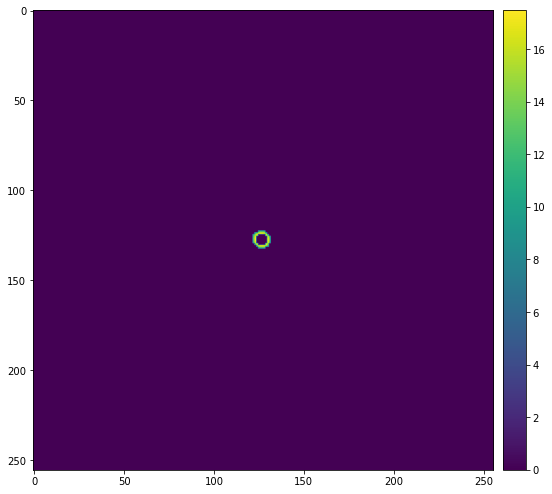

In [15]:
# get the outline of center disk 
thresh = 1.9 # threshhold of the center disk
outline0 = np.copy(gray)
outline0_id = np.where(img_grad>=thresh)
outline0_rvid = np.where(img_grad<thresh)
outline0[outline0_rvid[0],outline0_rvid[1]] =0
fig =plt.figure(1, figsize=(30, 30))
grid=AxesGrid(fig, 236, nrows_ncols=(1,1),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(outline0, cmap=plt.cm.viridis)
grid.cbar_axes[0].colorbar(im)

(12, 12)


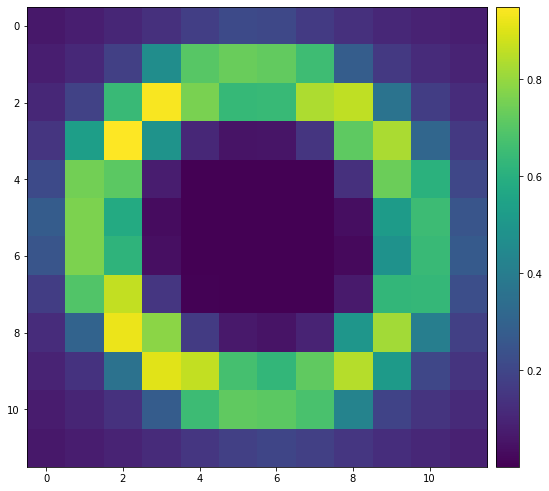

In [16]:
# adjust the size and the position of the template by change the numbers in the template equation
#(x,y) x is vitaul direction from top to bottom; y is horizontal direction from left to right; 
EMData = np.float32(img_grad)
template = EMData[outline0_id[0].min()-1:outline0_id[0].max()+2,outline0_id[1].min()-1:outline0_id[1].max()+2]/4
fig =plt.figure(1, figsize=(30, 30))
grid=AxesGrid(fig, 236, nrows_ncols=(1,1),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(template, cmap=plt.cm.viridis)
grid.cbar_axes[0].colorbar(im)
print(template.shape)

In [17]:
# check yhe position of center disk
X, Y = np.meshgrid(np.arange(0, img_grad.shape[1]), np.arange(0, img_grad.shape[0]))
x_center, y_center =np.average(img_grad * X), np.average(img_grad * Y)
x_center/=np.average(img_grad)
y_center/=np.average(img_grad)
cell0 = [x_center, y_center]
print(cell0)

[124.94039146978274, 126.0125966970417]


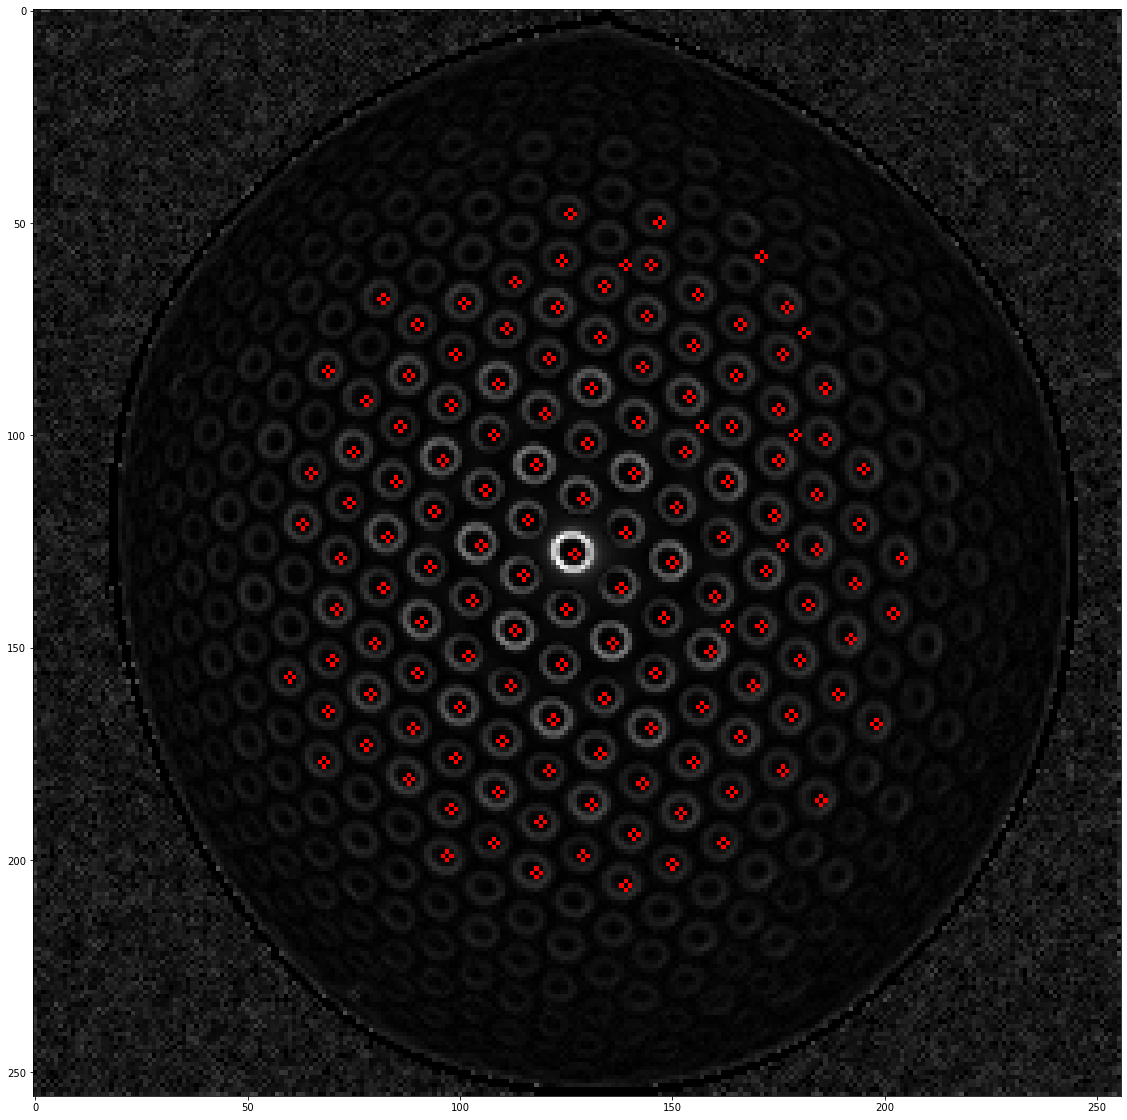

In [18]:
#fit templates roughly
rgb_frame=cv2.cvtColor(EMData/np.max(EMData), cv2.COLOR_GRAY2BGR)
corr_coeff, peak_idx = MatchTemplate(EMData, template, 5, 0.4)
for i in range(0, peak_idx.shape[0]):
    cv2.circle(rgb_frame,(int(peak_idx[i, 1]+template.shape[0]/2),int(peak_idx[i, 0]+template.shape[1]/2)),1,(255,0,0))
plt.figure(figsize=(20,20))
plt.imshow(rgb_frame)
peak_pos = peak_idx

In [19]:
#transform 
EMData = EMData - np.min(EMData)
template = template - np.min(template)
sub_peak = MatchSubpixTemplate(EMData, template, peak_idx)

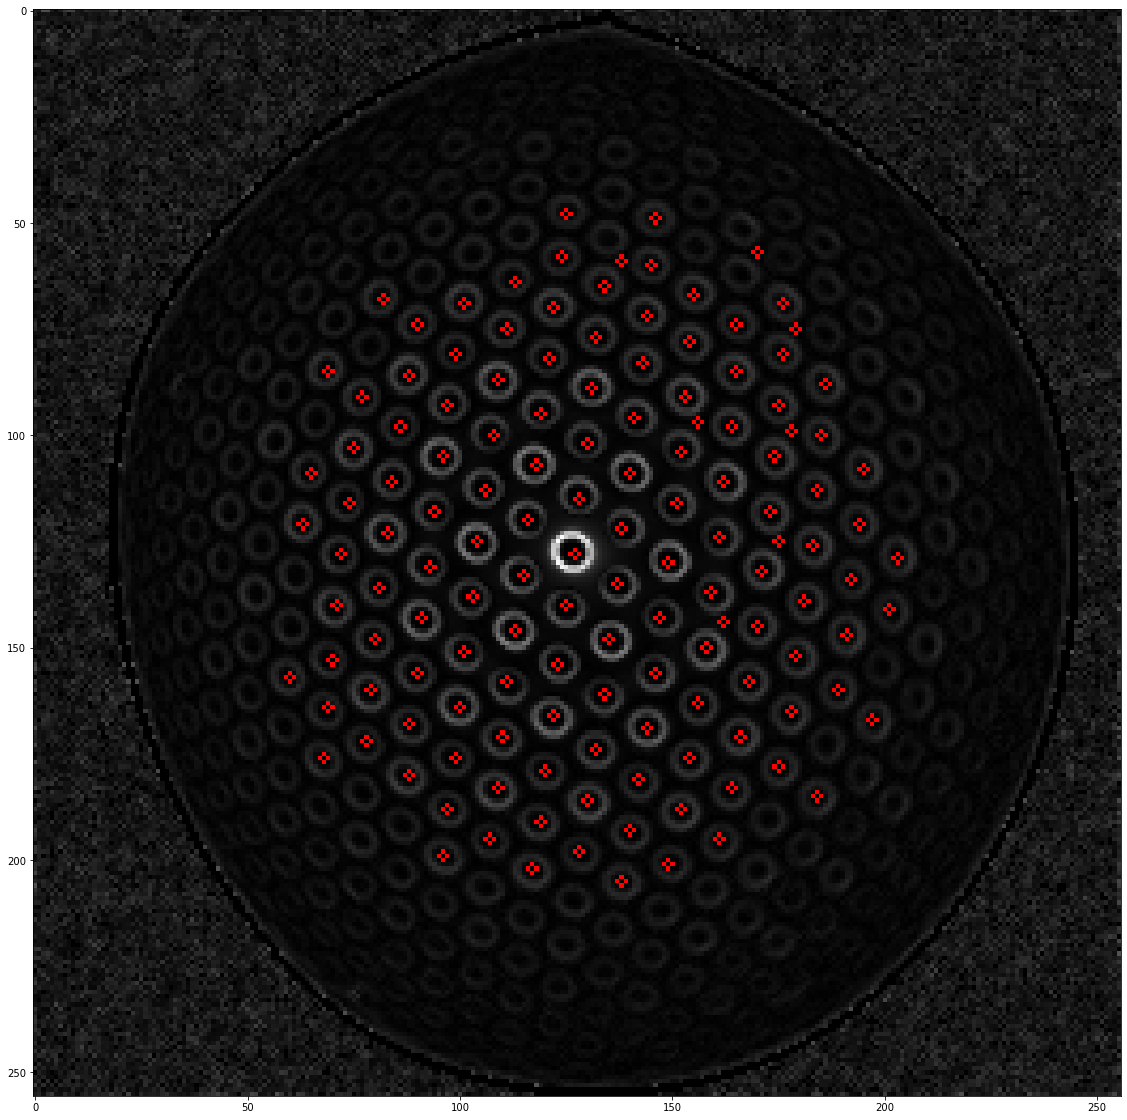

In [20]:
#cv2.circle(rgb_frame,(int(sub_peak[i, 1]),int(sub_peak[i, 0])),1,(255,0,0))
rgb_frame=cv2.cvtColor(EMData/np.max(EMData), cv2.COLOR_GRAY2BGR)
for i in range(0, sub_peak.shape[0]):
    cv2.circle(rgb_frame,(int(sub_peak[i, 1]),int(sub_peak[i, 0])),1,(255,0,0))
plt.figure(figsize=(20,20))
plt.imshow(rgb_frame)

#### Step 1.4 Refine the position of disks manually by GUI

In [22]:
# change coordination of the positions
points = np.zeros(peak_idx.shape)
points[:,0] = sub_peak[:,1]
points[:,1] = sub_peak[:,0]

The GUI function is used to help you adjust the position of centers manually if the auto-fitted positions are not accurate. 

In this step, you can change the positions of points by click the mouse:
1. Left click: The point that is nearest to the mouse will move into the position under the left click
2. Left click + Shift: Add a point
3. Right click: Delete a point

<IPython.core.display.Javascript object>


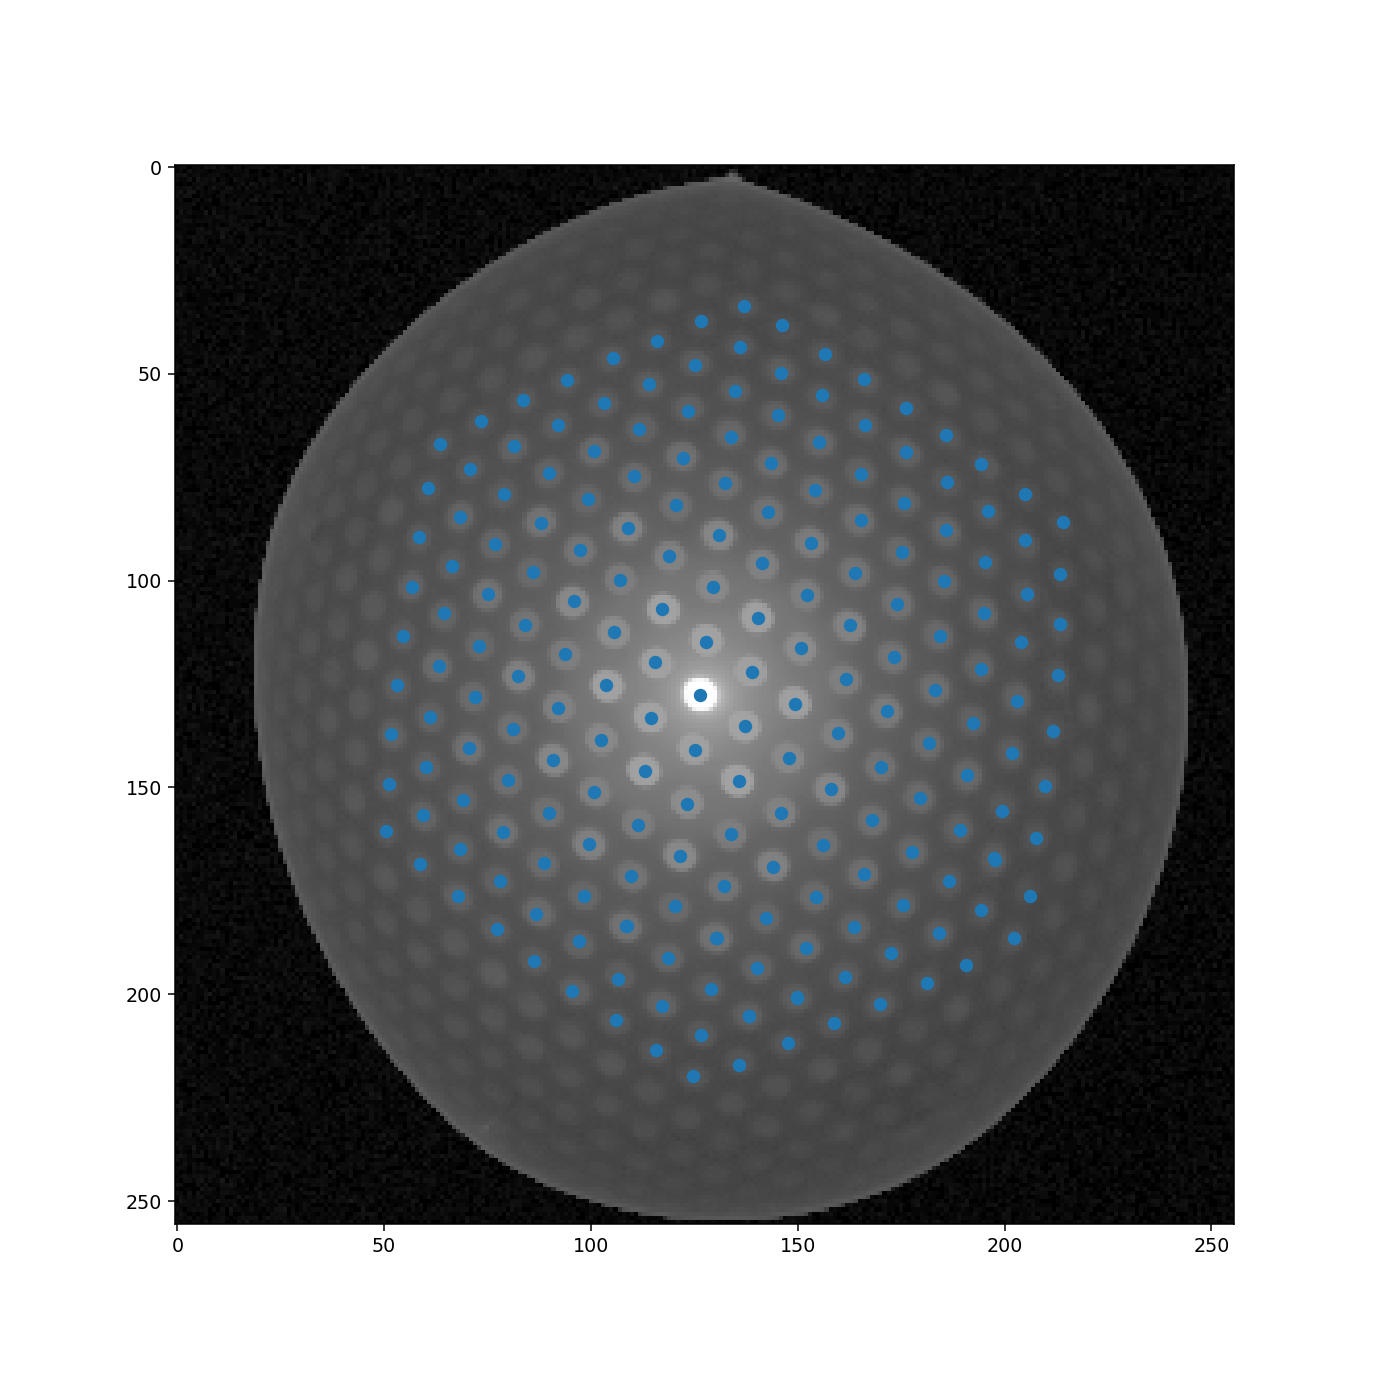

In [29]:
# plot the postions on the image and change the positon of disks
fig, ax = plt.subplots(figsize=(10, 10))
scat = ax.scatter(points[:, 0], points[:, 1])
plt.imshow(gray,cmap=plt.cm.gray )  # Replace with your image

def onclick(event):
    global points
    if event.inaxes is not ax:
        return

    # Check distance to all points
    distances = np.sqrt((points[:, 0] - event.xdata)**2 + (points[:, 1] - event.ydata)**2)
    index = np.argmin(distances)

    # Left click (button == 1) with Shift key to add a point
    if event.button == 1 and event.key == 'shift':
        print(f"Adding point at: ({event.xdata}, {event.ydata})")
        points = np.vstack([points, [event.xdata, event.ydata]])
    # Left click (button == 1) to modify the position if close enough
    elif distances[index] < 20 and event.button == 1:
        print(f"Moving point index: {index}")
        points[index] = [event.xdata, event.ydata]
    # Right click (button == 3) to delete if close enough
    elif distances[index] < 20 and event.button == 3:
        print(f"Deleting point index: {index}")
        points = np.delete(points, index, axis=0)

    scat.set_offsets(points)
    fig.canvas.draw_idle()

fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()

In [30]:
np.save(folder +'BJ_515_centers_3.npy',points)

# save the positions of centers
np.save(folder +'BJ_515_centers.npy',points)

In [28]:
# relod the centers if you want to change the centers
points=np.load(folder +'BJ_515_centers_2.npy')

In [ ]:
#End